In [79]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import scipy.integrate as integrate
import scipy.optimize as optimize
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4

In [126]:
nx_new = 192
ny_new = 192
nz_new = 6
Htot = 5000

input_dir = '/glade/scratch/bachman/Ian_QG/QGN_Beta/TEST/CHPL/'
input_file = 'q.0000010000.nc'

f = netCDF4.Dataset(input_dir + input_file, 'r', format='NETCDF4')
x_old = f['x'][:]
y_old = f['y'][:]
z_old = f['z'][:]
t_old = f['time'][:]
q_old = f['q'][:,:,:,:]

nx_old = len(x_old)
ny_old = len(y_old)
nz_old = len(z_old)

f.close()

new_background_file = '/glade/work/bachman/Jupyter_Notebooks/Ian_QG_Chapel/background_eady_6.nc1'
f = netCDF4.Dataset(new_background_file, 'r', format='NETCDF4')

z_new = f['zl'][:]*Htot

f.close()

In [140]:
Lx = 2*(-x_old[0] + (x_old[1] - x_old[0])/2)
Ly = 2*(-y_old[0] + (y_old[1] - y_old[0])/2)
dx_new = Lx / nx_new
dy_new = Ly / ny_new

x_new = np.zeros(nx_new)
y_new = np.zeros(ny_new)

for i in range(0,nx_new):
    x_new[i] = -(Lx+dx_new)/2 + dx_new*(i+1);

for j in range(0,ny_new):
    y_new[j] = -(Ly+dy_new)/2 + dy_new*(j+1);

In [127]:
q_tmp1 = np.zeros((1, nz_old, ny_old, nx_new))

lpk = int(nx_old/2-1)
lnk = int(nx_old/2)
scaling_fac = nx_new / nx_old

for z in range(0,nz_old):
    for y in range(0,ny_old):
        tmp = np.zeros(nx_new, dtype=np.complex) 
        fftq = fft(q_old[0,z,y,:])
        tmp[0:lpk] = fftq[0:lpk]
        tmp[(nx_new-int(nx_old/2)):nx_new] = fftq[lnk:]
        q_tmp1[0,z,y,:] = np.real(ifft(tmp)) * scaling_fac


        
q_tmp2 = np.zeros((1, nz_old, ny_new, nx_new))

lpk = int(ny_old/2-1)
lnk = int(ny_old/2)
scaling_fac = ny_new / ny_old

for z in range(0,nz_old):
    for x in range(0,nx_new):
        tmp = np.zeros(ny_new, dtype=np.complex) 
        fftq = fft(q_tmp1[0,z,:,x])
        tmp[0:lpk] = fftq[0:lpk]
        tmp[(nx_new-int(nx_old/2)):nx_new] = fftq[lnk:]
        q_tmp2[0,z,:,x] = np.real(ifft(tmp)) * scaling_fac
        
        
        
q_new = np.zeros((1, nz_new, ny_new, nx_new))
spl_degree = min(nz_old-1, 5)        
for y in range(0,ny_new):
    for x in range(0,nx_new): 
        spl = UnivariateSpline(z_old, q_tmp2[0,:,y,x],k=spl_degree)
        q_new[0,:,y,x] = spl(z_new)

In [147]:
# Write to NetCDF files for Chapel

f = netCDF4.Dataset(input_dir + input_file + '_interp', 'w', format='NETCDF4')
 
tmp = f.createDimension('time', 1)    
tmp = f.createDimension('z', nz_new)
tmp = f.createDimension('y', ny_new)
tmp = f.createDimension('x', nx_new)

tmp_time = f.createVariable('time', 'f8', ('time'))
setattr(tmp_time, 'units', "timesteps")

tmp_z = f.createVariable('z', 'f8', ('z'))
setattr(tmp_z, 'units', "meters")

tmp_y = f.createVariable('y', 'f8', ('y'))
setattr(tmp_y, 'units', "meters")

tmp_x = f.createVariable('x', 'f8', ('x'))
setattr(tmp_x, 'units', "meters")

tmp_q_new = f.createVariable('q', 'f8', ('time','z','y','x'))
setattr(tmp_q_new, 'units', "seconds-1")

tmp_time[:] = t_old
tmp_x[:] = x_new
tmp_y[:] = y_new
tmp_z[:] = z_new
tmp_q_new[:,:,:,:] = q_new

f.close()

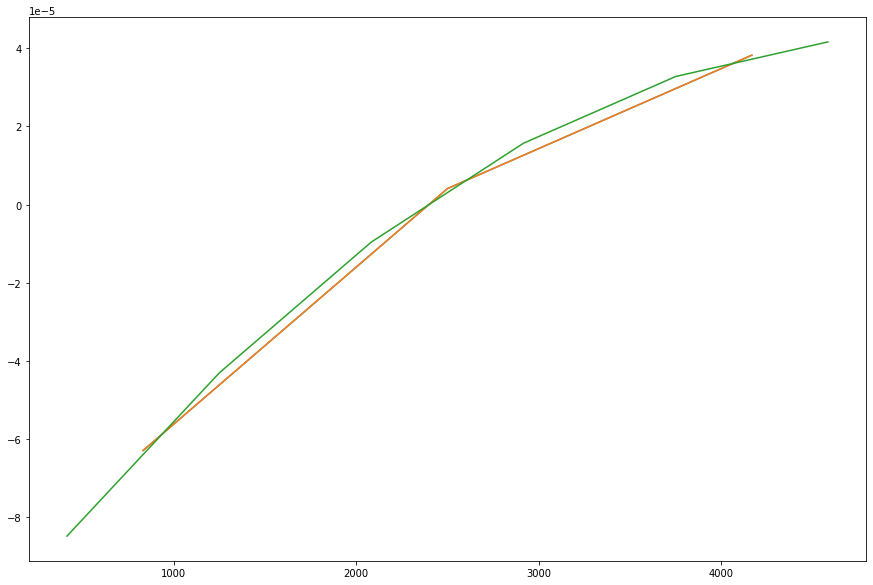

In [125]:
## Sanity check

from matplotlib import pyplot as plt
import matplotlib

fig,axs = plt.subplots(1,1,figsize=(15,10))
plt.plot( z_old, q_old[0,:,0,0])
plt.plot( z_old, q_tmp2[0,:,0,0])
plt.plot( z_new, q_tmp3[0,:,0,0])